# Classify correct masks
Classify whether the person is wearing a mask correct or incorrect.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print("TensorFlow version:", tf.__version__) 
from functools import partial

TensorFlow version: 2.9.2


## Load images

In [ ]:
data_dir = pathlib.Path("drive/MyDrive/mask_detection/face_data/imgs")

batch_size = 32
img_height = img_width = 128

df = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  label_mode="binary",
  batch_size=batch_size)



Found 9635 files belonging to 2 classes.


### visualize data

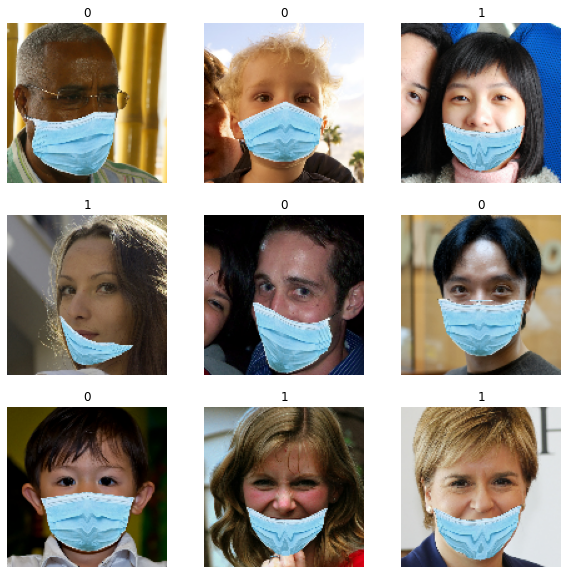

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


0 means mask  
1 means no mask or uncorrect mask

## Preprocessing

In [ ]:
scaled_data = df.map(lambda x,y: (x/255, y))
grey_data = scaled_data.map(lambda x, y: (tf.image.rgb_to_grayscale(x),y))

In [ ]:
train_size = int(len(grey_data)*.8)
val_size = int(len(grey_data)*.2)


train_data = grey_data.take(train_size)
val_data = grey_data.skip(train_size).take(val_size)



In [ ]:
len(train_data)

241

In [ ]:
data_it = train_data.as_numpy_iterator()
batch = data_it.next()
batch[0].shape

(32, 128, 128, 1)

In [ ]:
# make the dataset more performant

train_data = train_data.prefetch(buffer_size=32)
val_data = val_data.prefetch(buffer_size=32)

## Build the Model

In [ ]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")


model = tf.keras.Sequential([
    DefaultConv2D(filters=32, kernel_size=5, input_shape=[128, 128, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=64),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/MyDrive/mask_detection/checkpoints/mask_detection_nn.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2)
backup_cb = tf.keras.callbacks.BackupAndRestore(backup_dir="drive/MyDrive/mask_detection/checkpoints")


In [ ]:
hist = model.fit(train_data, epochs=4, validation_data=val_data, callbacks=[early_stopping_cb, backup_cb])

Epoch 1/15
241/241 [==============================] - 1109s 5s/step - loss: 0.4712 - accuracy: 0.7613 - val_loss: 0.1187 - val_accuracy: 0.9568
Epoch 2/15
241/241 [==============================] - 110s 450ms/step - loss: 0.1679 - accuracy: 0.9354 - val_loss: 0.1077 - val_accuracy: 0.9693
Epoch 3/15
241/241 [==============================] - 110s 451ms/step - loss: 0.1343 - accuracy: 0.9547 - val_loss: 0.0630 - val_accuracy: 0.9797
Epoch 4/15
241/241 [==============================] - 109s 446ms/step - loss: 0.0995 - accuracy: 0.9713 - val_loss: 0.0487 - val_accuracy: 0.9854
Epoch 5/15
241/241 [==============================] - 110s 451ms/step - loss: 0.0754 - accuracy: 0.9748 - val_loss: 0.0509 - val_accuracy: 0.9859
Epoch 6/15
241/241 [==============================] - 110s 451ms/step - loss: 0.0627 - accuracy: 0.9808 - val_loss: 0.0385 - val_accuracy: 0.9901
Epoch 7/15
241/241 [==============================] - 108s 441ms/step - loss: 0.0526 - accuracy: 0.9847 - val_loss: 0.0350 - v

(0.0, 1.0)

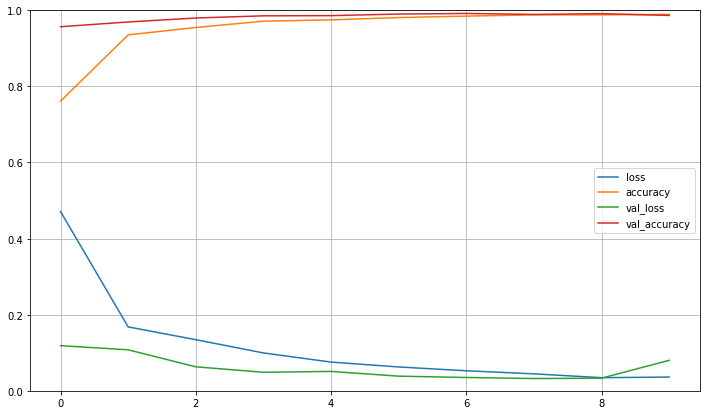

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(12, 7))
plt.grid(True)
plt.gca().set_ylim(0,1)

## Save the model for serving

In [ ]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8),))
def preprocessing(input_tensor):
    output_tensor = tf.cast(input_tensor, dtype=tf.float32)
    output_tensor = tf.image.resize_with_pad(output_tensor, target_height=128, target_width=128)
    output_tensor = keras_applications.mobilenet.preprocess_input(output_tensor, data_format="channels_last")
    return output_tensor

In [ ]:
version = 1
export_path = os.path.join("drive/MyDrive/mask_detection/models", str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}


export_path = drive/MyDrive/mask_detection/models/1




Saved model:
total 230
drwx------ 2 root root   4096 Oct 25 18:56 assets
-rw------- 1 root root  22604 Oct 25 18:56 keras_metadata.pb
-rw------- 1 root root 203939 Oct 25 18:56 saved_model.pb
drwx------ 2 root root   4096 Oct 25 18:56 variables


In [ ]:
model.save("drive/MyDrive/mask_detection/models/final_face_detection_m.h5")

In [ ]:
! saved_model_cli show --dir "drive/MyDrive/mask_detection/models/1" --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 128, 128, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          conv2d